In [1]:
import math
import warnings

import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from bayesanova.samplers.stein import (GPSVGD, GPSliceSVGD, SteinIMQkernel,
                                       SteinRBFkernel)
from torch.optim import SGD, Adagrad, RMSprop

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
N = 100
num_particles = 100
batch_shape = torch.Size([num_particles])


train_x = torch.linspace(0, 1, N).unsqueeze(-1)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2
train_y = train_y.squeeze(-1) # train y is always a vector 

batch_train_x = train_x.expand(num_particles, -1, -1)
batch_train_y = train_y.expand(num_particles, -1)
print('shape', batch_train_x.shape, batch_train_y.shape)



shape torch.Size([100, 100, 1]) torch.Size([100, 100])


In [3]:

p = 1 # Increase p to increase the variance of prior => non informative prior
class GPmodel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, batch_shape=torch.Size([])):
        super(GPmodel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=batch_shape)
        self.mean_module.register_prior("mean_prior", gpytorch.priors.NormalPrior(0, 10), "constant")

        lengthscale_prior = gpytorch.priors.GammaPrior(3.0/p, 6.0/p)
        outputscale_prior = gpytorch.priors.GammaPrior(2.0/p, 0.15/p)
        

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_prior=lengthscale_prior, batch_shape=batch_shape
            ),
            outputscale_prior=outputscale_prior,batch_shape=batch_shape
        )

        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        self.covar_module.outputscale = outputscale_prior.mean

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [4]:
# Create the batch model 

likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=batch_shape, 
                                                        noise_constraint=gpytorch.constraints.Positive(),
                                                        noise_prior=gpytorch.priors.GammaPrior(3.0, 6.0),
                                                        )

model = GPmodel(batch_train_x, batch_train_y, likelihood, batch_shape=batch_shape)

In [5]:
kernel =  SteinRBFkernel()
kernel = SteinIMQkernel()
optimizer = RMSprop # Trying different optimizers to have an adaptive stepsize 
optimizer_params = {'lr':0.01, 'momentum':0.9}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'factor':0.5, 'patience':50, 'verbose':False, 'threshold':0.00001, 'min_lr':1e-5}

# Choice of stein algorithm
choice = 1 # if 1 then simple stein else sliced stein

if choice == 1:
    estimator = GPSVGD(model=model,
                        kernel=kernel,
                        optimizer=optimizer,
                        num_particles=num_particles,
                        mode='multi',
                        optimizer_params = optimizer_params, 
                        r_coef=1,
                        num_chains=1, 
                        warmup_steps=1000,
                        scheduler=scheduler, 
                        scheduler_params = scheduler_params,
                        stochastic=False, 
                        init_strategy='prior')
else: 
    # Need the Sliced_Kernelized_Stein_Discrepancy package 
    estimator = GPSliceSVGD(model=model,
                        kernel=kernel,
                        optimizer=optimizer,
                        num_particles=num_particles,
                        optimizer_params = optimizer_params, 
                        r_coef=1,
                        num_chains=1, 
                        warmup_steps=1000,
                        scheduler=scheduler, 
                        scheduler_params = scheduler_params,
                        init_strategy='prior', 
                        n_g_update=10)

In [6]:
estimator.run(batch_train_x, batch_train_y)

Warm up: 100%|██████████| 1000/1000 [00:18<00:00, 54.00it/s, gradnorm=0.0, lr=0.000161]


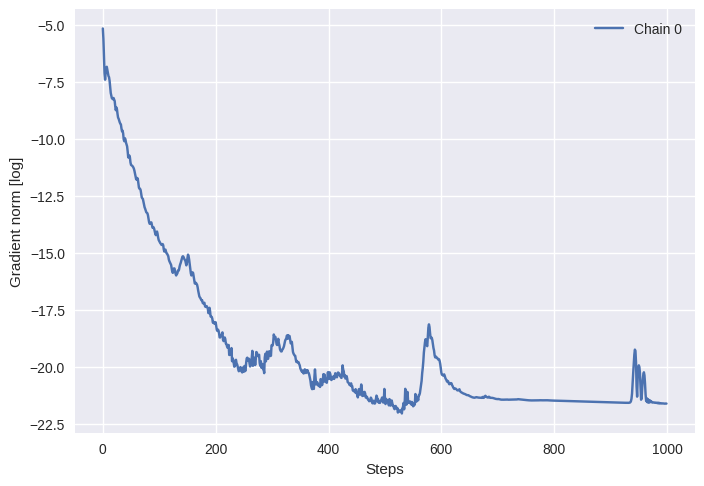

In [7]:
estimator.summary()

In [8]:
samples = estimator.get_named_particles()

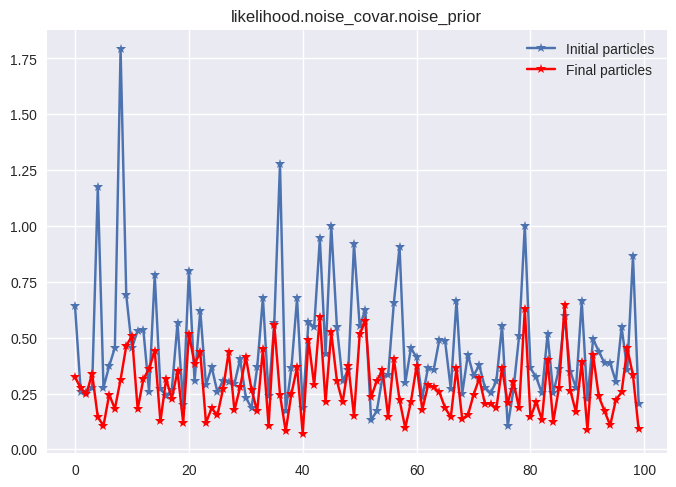

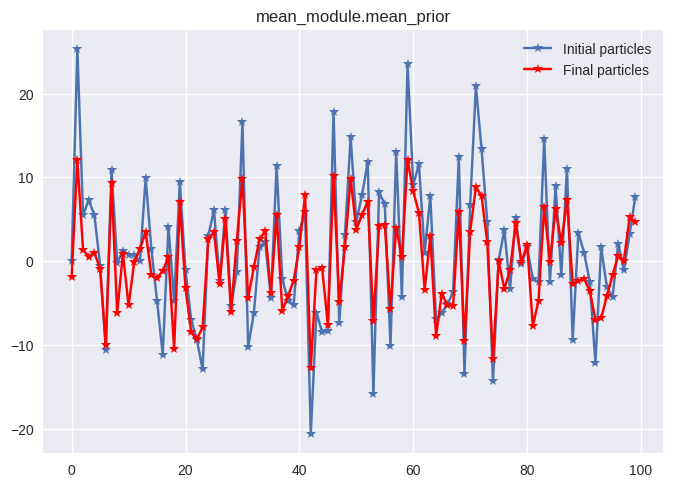

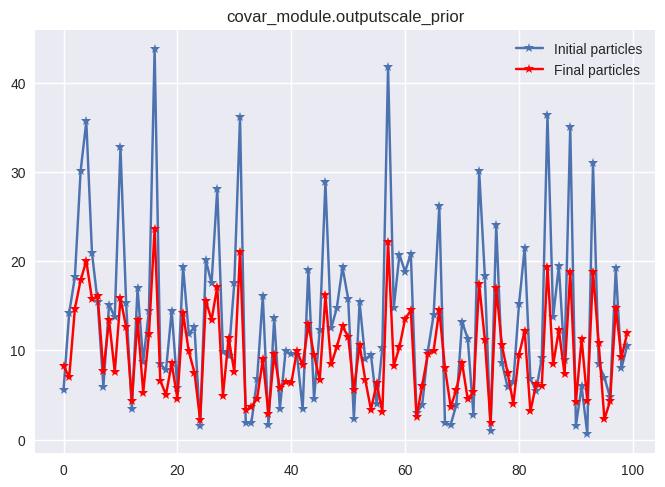

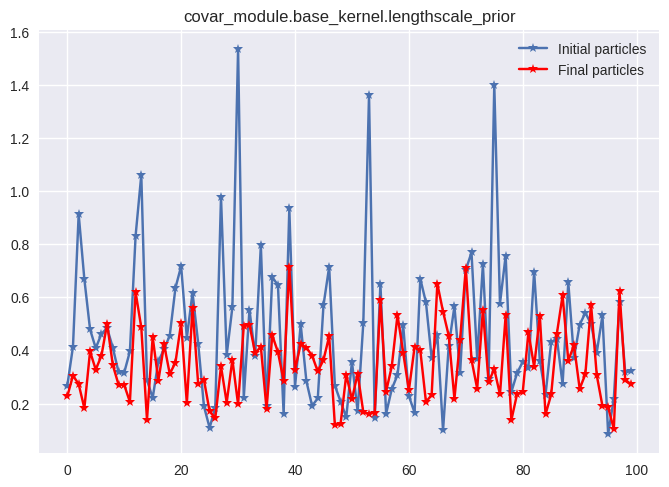

In [9]:
for (name, s0), s1 in zip(estimator.initial_particles[0].items(), samples.values()):
    plt.figure()
    plt.plot(s0.squeeze(-1).squeeze(-1), '-*', label='Initial particles')
    plt.plot(s1.squeeze(-1).squeeze(-1), 'r-*', label='Final particles')
    plt.title(name)
    plt.legend()

In [10]:
for name, s0 in samples.items():
    print('Estimated value of %s : %0.4f +/- %0.4f'%(name, s0.mean().item(), s0.std().item()))

Estimated value of likelihood.noise_covar.noise_prior : 0.2803 +/- 0.1361
Estimated value of mean_module.mean_prior : -0.0392 +/- 5.6837
Estimated value of covar_module.outputscale_prior : 9.7055 +/- 5.0567
Estimated value of covar_module.base_kernel.lengthscale_prior : 0.3457 +/- 0.1430


In [11]:
model.eval()
test_x = torch.linspace(0, 1, 101).unsqueeze(-1)
test_y = torch.sin(test_x * (2 * math.pi))
expanded_test_x = test_x.unsqueeze(0).repeat(num_particles, 1, 1)
output = model(expanded_test_x)

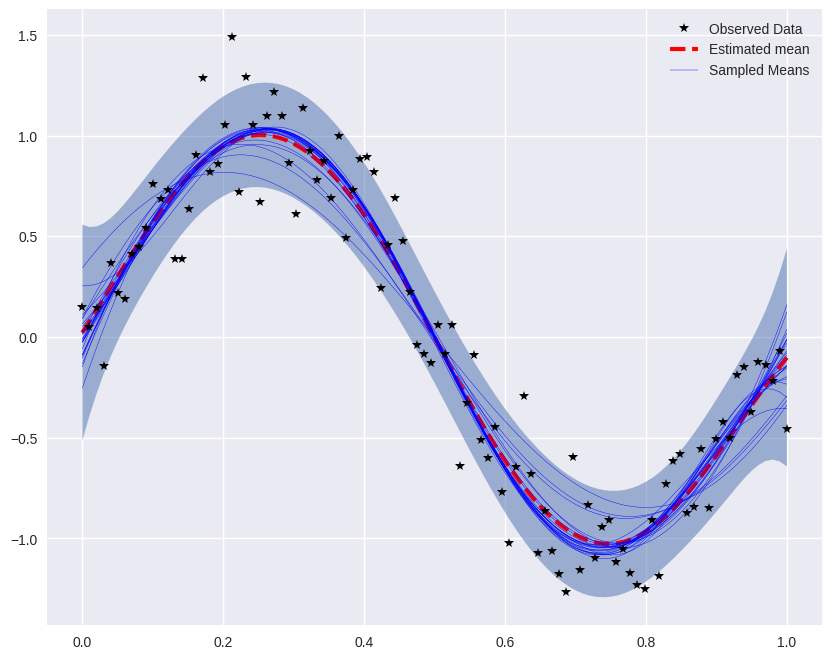

In [12]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', zorder=10)
    
    global_mean = torch.mean(output.mean, dim=0, keepdim=True)
    mean = torch.mean(global_mean, dim=0)
    ax.plot(test_x.numpy(), mean.detach().numpy(), '--r', linewidth=3)
    
    for i in range(min(num_particles, 25)):
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), output.mean[i].detach().numpy(), 'b', linewidth=0.3)
    
    # Shade between the lower and upper confidence bounds
    global_variance = output.variance + \
                   torch.abs(output.mean - global_mean) ** 2
    var = torch.mean(global_variance, dim=0)
    lower = mean - 2 * torch.sqrt(var)
    upper = mean + 2 * torch.sqrt(var)
    
    #lower, upper = output.confidence_region()
    #lower = lower.mean(axis=0).numpy()
    #upper = upper.mean(axis=0).numpy()
    
    ax.fill_between(test_x.numpy().squeeze(-1), lower, upper, alpha=0.5)
    ax.legend(['Observed Data', 'Estimated mean', 'Sampled Means'])

**Conclusion** : we are initializing the Stein sampler with prior samples. When the prior produces samplers far from the target distribution, it seems that the Stein sampler fails to find the target space.
